Simulating hop 1...
Simulating hop 2...
Simulating hop 3...
Simulating hop 4...
Simulating hop 5...
Simulating hop 6...
Simulating hop 7...
Simulating hop 8...
Simulating hop 9...
Simulating hop 10...
Simulating hop 11...
Simulating hop 12...
Simulating hop 13...
Simulating hop 14...
Simulating hop 15...
Simulating hop 16...
Simulating hop 17...
Simulating hop 18...
Simulating hop 19...
Simulating hop 20...
Simulating hop 21...
Simulating hop 22...
Simulating hop 23...
Simulating hop 24...
Simulating hop 25...
Simulating hop 26...
Simulating hop 27...
Simulating hop 28...
Simulating hop 29...
Simulating hop 30...
Simulating hop 31...
Simulating hop 32...
Simulating hop 33...
Simulating hop 34...
Simulating hop 35...
Simulating hop 36...
Simulating hop 37...
Simulating hop 38...
Simulating hop 39...
Simulating hop 40...
Simulating hop 41...
Simulating hop 42...
Simulating hop 43...
Simulating hop 44...
Simulating hop 45...
Simulating hop 46...
Simulating hop 47...
Simulating hop 48...
S

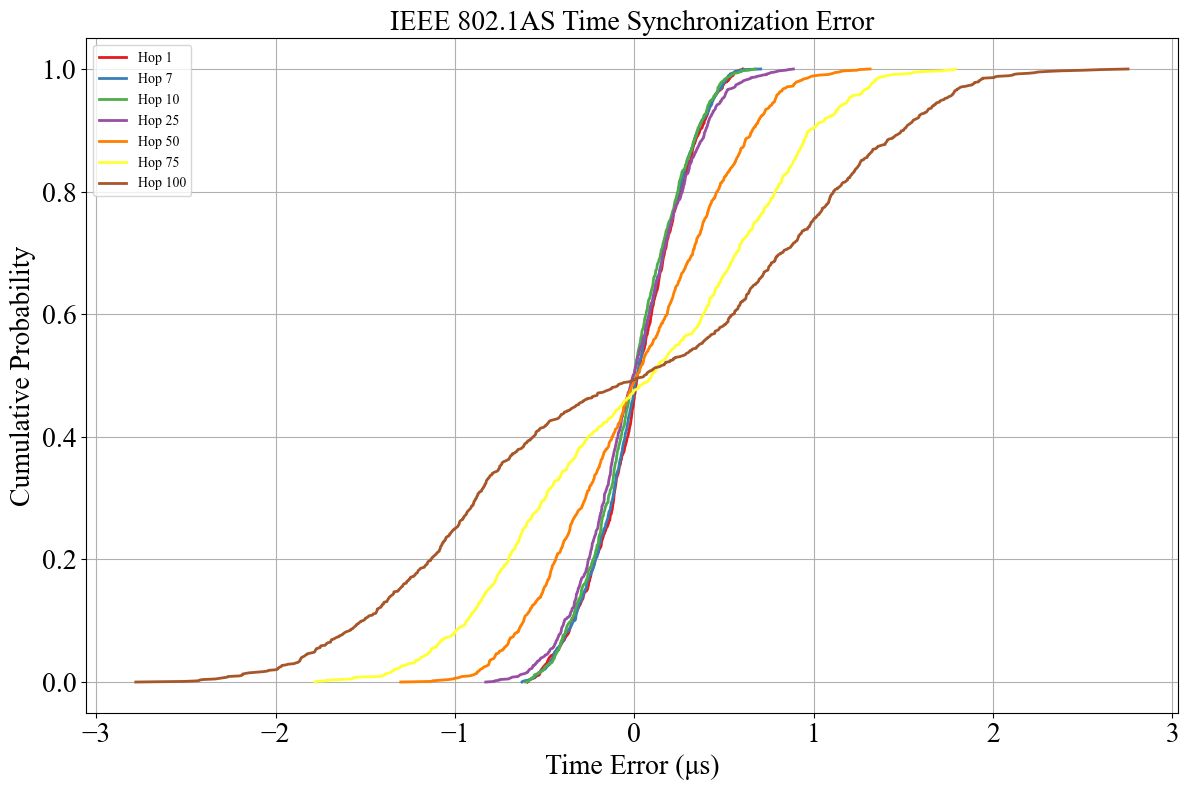

In [1]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/4/12 20:11
*  @Project :   pj_gptp_simulation
*  @Description :   从ieee8021as_simulation.py 拷贝来的版本
*  @FileName:   main.py
**************************************
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

# Create the output directory
os.makedirs("version/20250413/output_data", exist_ok=True)

# Parameters from the paper
PHY_JITTER_MAX = 8e-9  # 8 ns
CLOCK_GRANULARITY = 8e-9  # 8 ns
MAX_DRIFT_RATE = 10e-6  # 10 ppm
NR_ERROR = 0.1e-6  # 0.1 ppm
RESIDENCE_TIME_MAX = 1e-3  # 1 ms
PROPAGATION_DELAY = 62e-9  # 62 ns
SYNC_INTERVAL = 31.25e-3  # 31.25 ms
NUM_SAMPLES = 1000  # Samples per hop


def calculate_time_error(hops, sync_interval=SYNC_INTERVAL):
    """
    Calculate time synchronization error based on the paper's equations.
    """
    # Basic error from clock drift (equation 11)
    gm_drift = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
    node_drift = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
    basic_error = (node_drift - gm_drift) * sync_interval

    # Errors due to PHY jitter and clock granularity
    if hops > 1:
        # Timestamp error
        timestamp_error = np.random.uniform(0, PHY_JITTER_MAX) + np.random.uniform(0, CLOCK_GRANULARITY)

        # Error propagation factor based on equations (16)-(23)
        error_factor = np.random.uniform(0.5, 1.0)

        # Calculate accumulated error (grows with hop count)
        accumulated_error = timestamp_error * error_factor * hops

        # From Figure 10 - error grows faster after ~30 hops
        if hops > 30:
            accumulated_error *= 1 + (hops - 30) / 100
    else:
        accumulated_error = 0

    # Total error
    total_error = basic_error + accumulated_error

    # Randomize sign (error can be positive or negative)
    if np.random.random() < 0.5:
        total_error = -total_error

    return total_error


# Generate data for all hops (1-100)
all_data = {}
for h in range(1, 101):
    print(f"Simulating hop {h}...")
    hop_errors = [calculate_time_error(h) for _ in range(NUM_SAMPLES)]
    all_data[h] = hop_errors

# Save to CSV with each column representing one hop
df = pd.DataFrame({hop: all_data[hop] for hop in range(1, 101)})
df.to_csv("version/20250413/output_data/te_data.csv", index=False)

# Target hops for plotting
target_hops = [1, 7, 10, 25, 50, 75, 100]
colors = {
    '1': '#E41A1C',  # 深红
    '2': '#377EB8',  # 深蓝
    '3': '#4DAF4A',  # 深绿
    '4': '#984EA3',  # 紫色
    '5': '#FF7F00',  # 橙色
    '6': '#FFFF33',  # 黄色
    '7': '#A65628'  # 棕色
}

# Create plot of time error distributions
plt.figure(figsize=(12, 8))

for i, hop in enumerate(target_hops):
    # Extract data for this hop and convert to microseconds
    errors = np.array(all_data[hop])
    errors_us = errors * 1e6

    # Sort errors for CDF plot
    sorted_errors = np.sort(errors_us)
    cumulative_prob = np.linspace(0, 1, len(sorted_errors))

    plt.plot(sorted_errors, cumulative_prob,
             label=f'Hop {hop}',
             color=colors[str(i + 1)],
             linewidth=2)

# Configure plot appearance
plt.grid(True)
plt.xlabel('Time Error (μs)', fontname='Times New Roman', fontsize=20)
plt.ylabel('Cumulative Probability', fontname='Times New Roman', fontsize=20)
plt.title('IEEE 802.1AS Time Synchronization Error', fontname='Times New Roman', fontsize=20)
plt.legend(fontsize=20, prop={'family': 'Times New Roman'})

plt.xticks(fontname='Times New Roman', fontsize=20)
plt.yticks(fontname='Times New Roman', fontsize=20)

plt.tight_layout()
plt.savefig("version/20250413/output_data/time_error_cdf.png", dpi=600)
plt.show()
